In [1]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from  torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

### Load Data

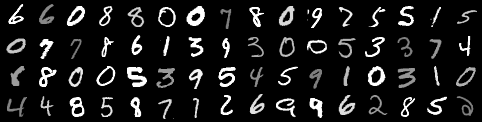

In [2]:
# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.ColorJitter(brightness=.5, hue=.3)])
train_dataset = MNIST(root=".././data", train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [55000, 5000])
test_set = MNIST(root=".././data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=256, drop_last=True, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4)

grid_img = torchvision.utils.make_grid(next(iter(train_loader))[0][:64], nrow=16)
transforms.ToPILImage()(grid_img)

### Define Model

In [43]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        std = torch.rand(1, device=tensor.device) * self.std
        return tensor + torch.randn(tensor.size(), device=tensor.device) * std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class Autoencoder(L.LightningModule):
    def __init__(self, latent_dim=16, gaussian_noise=0.0):
        super().__init__()
        self.save_hyperparameters()

        act_fn = nn.ReLU

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2),  # 1x28x28 -> 32x14x14
            act_fn(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 32x14x14 -> 32x14x14
            act_fn(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),  # 32x14x14 -> 64x7x7
            act_fn(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),  # 64x7x7 -> 64x4x4
            act_fn(),
            nn.Flatten(),  # 64x4x4 -> 1024
            nn.Linear(16 * 64, latent_dim),  # 1024 -> latent_dim
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 64),  # latent_dim -> 1024
            act_fn(),
            nn.Unflatten(1, (64, 4, 4)),  # 1024 -> 64x4x4
            nn.ConvTranspose2d(64, 64, kernel_size=3, output_padding=0, padding=1, stride=2, dilation=1),  # 64x4x4 -> 64x7x7
            act_fn(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, output_padding=1, padding=1, stride=2, dilation=1),  # 64x7x7 -> 32x14x14
            act_fn(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 32x14x14 -> 32x14x14
            act_fn(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, output_padding=1, padding=1, stride=2, dilation=1),  # 32x14x14 -> 1x28x28
            nn.Tanh(), # or Sigmoid?
        )

        self.noise = AddGaussianNoise(mean=0, std=gaussian_noise)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def _get_reconstruction_loss(self, batch):
        x, _ = batch
        x_hat = self.noise(x)
        y = self.forward(x_hat)
        loss = F.mse_loss(y, x, reduction="none") + F.l1_loss(y, x, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {"optimizer": optimizer}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss, prog_bar=True)

### Run Training

In [44]:
LATENT_DIM = 8
NUM_EPOCHS = 10
GAUSSIAN_NOISE = 0.5

trainer = L.Trainer(
    enable_checkpointing=False,
    logger=False,
    accelerator="auto",
    devices=1,
    max_epochs=NUM_EPOCHS,
)

model=Autoencoder(latent_dim=LATENT_DIM, gaussian_noise=GAUSSIAN_NOISE)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 73.2 K
1 | decoder | Sequential | 74.1 K
---------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.589     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 214/214 [00:05<00:00, 38.17it/s, train_loss=48.50, val_loss=47.00]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 214/214 [00:05<00:00, 38.15it/s, train_loss=48.50, val_loss=47.00]


In [75]:
val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
print("Val Loss:", val_result[0]['test_loss'], "|", "Test Loss:", test_result[0]['test_loss'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 76.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 73.30it/s]
Val Loss: 51.31986999511719 | Test Loss: 50.702728271484375


### Reconstruction (Autoencoding)

In [45]:
NUM_SAMPLES = 8

In [46]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True)
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

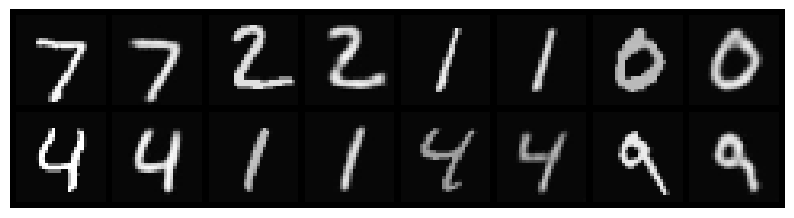

In [47]:
# 0% noise
input_imgs = next(iter(test_loader))[0][:NUM_SAMPLES]
visualize_reconstructions(model, input_imgs)

### Denoising

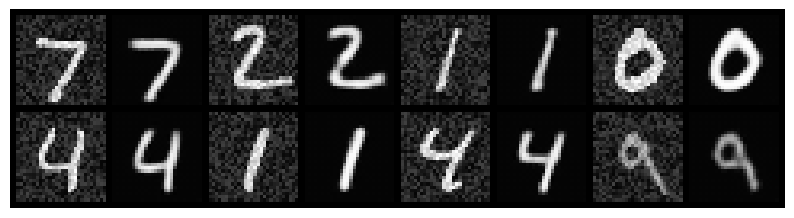

In [48]:
# 25% noise
input_imgs = 0.75 * next(iter(test_loader))[0][:NUM_SAMPLES] + 0.25 * torch.rand(NUM_SAMPLES, 1, 28, 28)
visualize_reconstructions(model, input_imgs)

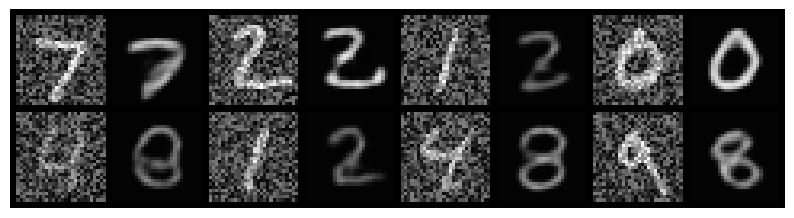

In [49]:
# 50% noise
input_imgs = 0.5 * next(iter(test_loader))[0][:NUM_SAMPLES] + 0.5 * torch.rand(NUM_SAMPLES, 1, 28, 28)
visualize_reconstructions(model, input_imgs)

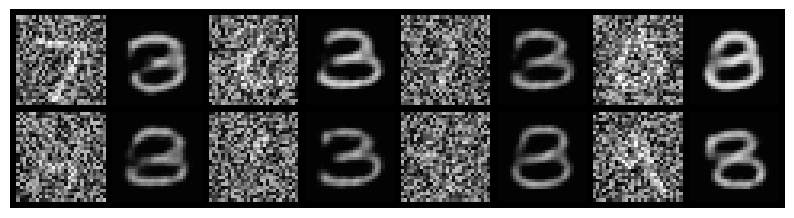

In [50]:
# 75% noise
input_imgs = 0.25 * next(iter(test_loader))[0][:NUM_SAMPLES] + 0.75 * torch.rand(NUM_SAMPLES, 1, 28, 28)
visualize_reconstructions(model, input_imgs)

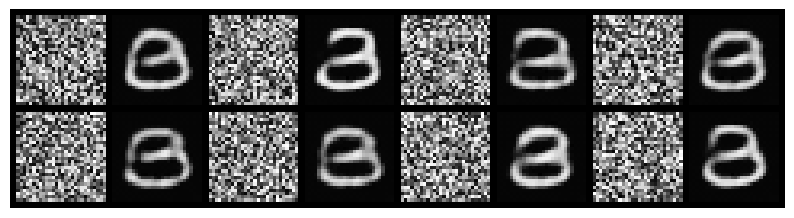

In [51]:
# 100% noise
input_imgs = torch.rand(NUM_SAMPLES, 1, 28, 28)
visualize_reconstructions(model, input_imgs)

### Generation (Sampling from Latent Space)

In [52]:
def generate_new_images(model, latent_vectors):
    model.eval()
    latent_vectors.to(device=model.device)
    with torch.no_grad():
        imgs = model.decoder(latent_vectors)
        imgs = imgs.cpu()

    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, pad_value=0.5)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

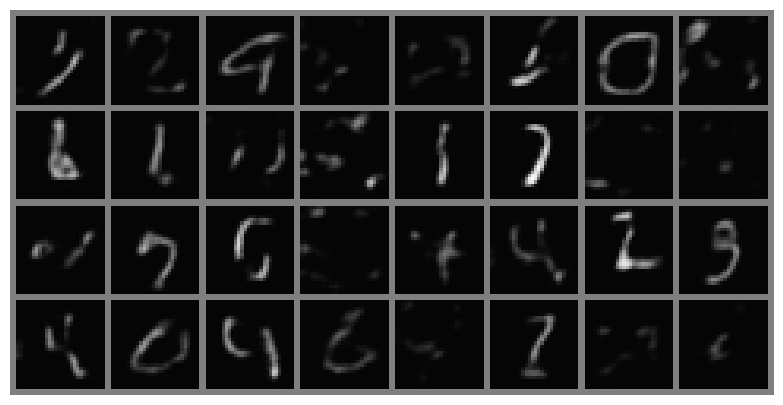

In [53]:
random_vectors = torch.randn(4 * NUM_SAMPLES, LATENT_DIM)
generate_new_images(model, random_vectors)